In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
from scipy.stats import kde
from tqdm import tqdm

from research.datasets import AutoLoadedDataset
from research.evaluator import evaluate, stats_to_df
from research.regression import GAMFit as FitterCls

In [2]:
PREFIX = 'gam'

if not os.path.exists('export'):
    os.mkdir('export')
if not os.path.exists('export/eps'):
    os.mkdir('export/eps')

plt.rcParams.update({
    "savefig.facecolor": (1, 1, 1, 1),
    "figure.figsize": (7, 4),
})

def save(fname):
    plt.savefig(f'export/{PREFIX}-{fname}', dpi=300)
    # Uncomment for eps files
    # plt.savefig(f'export/eps/{PREFIX}-{fname}.eps', dpi=1000, format='eps')

In [3]:
loaded = AutoLoadedDataset.load(seed=0)

Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\17_lmpavw.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\52_svmguide1.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\53_fourclass_scale.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\58_sarcasm_detection.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\77_WorkersCompensation.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\78_shill-bidding.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\79_art_daily_nojump3.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\80_art_daily_small_noise2.arff
Loaded 70 datasets


In [4]:
RESULTS = {}
for name, dataset in tqdm(loaded.items()):
    eval_stats = evaluate(dataset, FitterCls, retrain_on_filtered=False)
    RESULTS[name] = stats_to_df(
        eval_stats,
        [
            'target_coverage',
            'expected_coverage',
            'coverage',
            'mse_expected',
            'mse_filtered',
            'mse_prop_base',
            'comparison_loss',
        ],
        name
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [05:53<00:00,  5.04s/it]


In [5]:
data = pd.concat(RESULTS.values(), ignore_index=True)
data

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
0,0_kin8nm,0.1,0.110252,0.104090,0.015682,0.022845,0.574798,0.020315
1,0_kin8nm,0.2,0.232710,0.235043,0.017759,0.022555,0.567495,0.020315
2,0_kin8nm,0.3,0.309805,0.309524,0.018788,0.023140,0.582226,0.020315
3,0_kin8nm,0.4,0.404394,0.409646,0.021361,0.025794,0.649003,0.020315
4,0_kin8nm,0.5,0.507730,0.510684,0.024089,0.027131,0.682637,0.020315
...,...,...,...,...,...,...,...,...
695,9_wine_quality,0.6,0.785330,0.804465,0.476083,0.471127,0.973158,0.388566
696,9_wine_quality,0.7,0.785330,0.804465,0.476083,0.471127,0.973158,0.388566
697,9_wine_quality,0.8,0.918954,0.923403,0.489364,0.471538,0.974008,0.388566
698,9_wine_quality,0.9,0.918954,0.923403,0.489364,0.471538,0.974008,0.388566


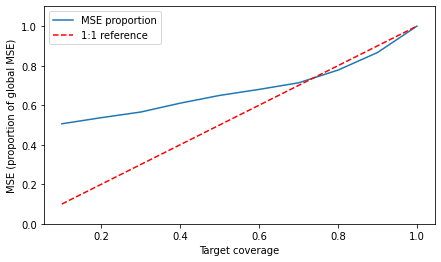

In [6]:
stats = data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

plt.plot(stats[:,0], stats[:,1], label='MSE proportion')
plt.plot([0.1, 1], [0.1, 1], 'r--', label='1:1 reference')

plt.xlabel('Target coverage')
plt.ylabel('MSE (proportion of global MSE)')
plt.ylim((0, 1.1))
plt.legend()
save('coverage-proportion reference')
plt.show()

In [7]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

array([[0.1       , 0.5059645 ],
       [0.2       , 0.5369103 ],
       [0.3       , 0.56543931],
       [0.4       , 0.61024846],
       [0.5       , 0.64947219],
       [0.6       , 0.67986446],
       [0.7       , 0.71319227],
       [0.8       , 0.77755935],
       [0.9       , 0.86637084],
       [1.        , 1.        ]])

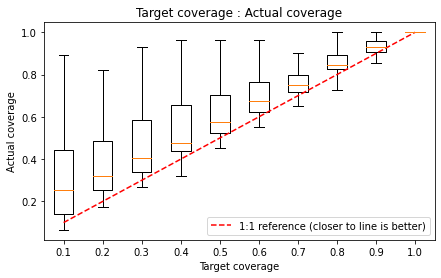

In [8]:
coverages = data.groupby('target_coverage').agg({
    'coverage': lambda x: list(x)
}).reset_index()['coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Actual coverage')
plt.title('Target coverage : Actual coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-actual')
plt.show()

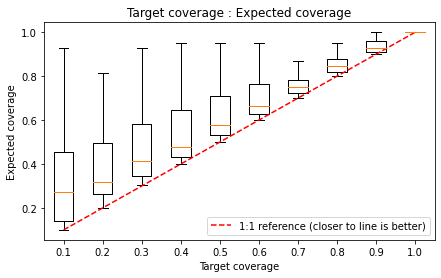

In [9]:
coverages = data.groupby('target_coverage').agg({
    'expected_coverage': lambda x: list(x)
}).reset_index()['expected_coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Expected coverage')
plt.title('Target coverage : Expected coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-expected')
plt.show()

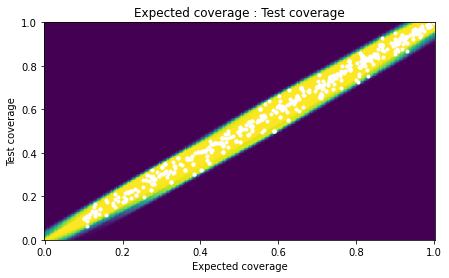

0.9958599383735424

In [10]:
x, y = data['expected_coverage'], data['coverage']

nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Expected coverage : Test coverage')
plt.xlabel('Expected coverage')
plt.ylabel('Test coverage')
save('expected-actual coverage heatmap')
plt.show()

x.corr(y)

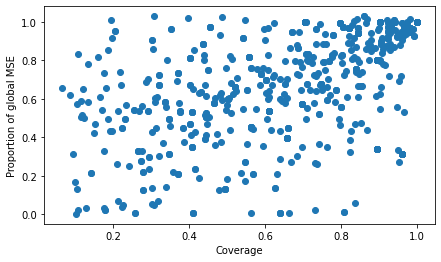

In [11]:
plt.scatter(data['coverage'], data['mse_prop_base'])

plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
plt.show()

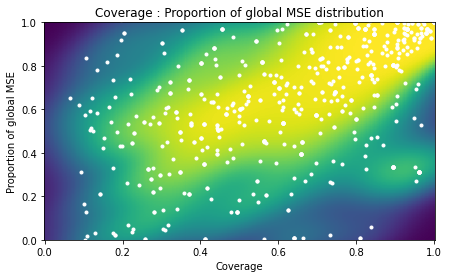

In [12]:
x, y = data['coverage'], data['mse_prop_base']
nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Coverage : Proportion of global MSE distribution')
plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
save('coverage-proportion heatmap')
plt.show()

In [13]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
})

,mse_prop_base
target_coverage,
0.1,0.505965
0.2,0.536910
0.3,0.565439
0.4,0.610248
0.5,0.649472
0.6,0.679864
0.7,0.713192
0.8,0.777559
0.9,0.866371


In [14]:
# Ones where we did well
data[np.abs(data['mse_prop_base'] / data['coverage']) < 0.05]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
20,11_analcatdata_supreme,0.1,0.276727,0.256790,0.000019,0.000017,0.003241,0.007272
21,11_analcatdata_supreme,0.2,0.276727,0.256790,0.000019,0.000017,0.003241,0.007272
22,11_analcatdata_supreme,0.3,0.643914,0.640123,0.000033,0.000031,0.006124,0.007272
23,11_analcatdata_supreme,0.4,0.643914,0.640123,0.000033,0.000031,0.006124,0.007272
24,11_analcatdata_supreme,0.5,0.643914,0.640123,0.000033,0.000031,0.006124,0.007272
25,11_analcatdata_supreme,0.6,0.643914,0.640123,0.000033,0.000031,0.006124,0.007272
26,11_analcatdata_supreme,0.7,0.731086,0.732716,0.000114,0.000117,0.022961,0.007272
460,54_COMET_MC_SAMPLE,0.1,0.105420,0.103751,0.000016,0.000015,0.001009,0.005074
461,54_COMET_MC_SAMPLE,0.2,0.408329,0.410626,0.000056,0.000055,0.003796,0.005074
462,54_COMET_MC_SAMPLE,0.3,0.408329,0.410626,0.000056,0.000055,0.003796,0.005074


In [15]:
# Ones where we did bad
data[(data['mse_prop_base'] / data['coverage']) > 5]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
0,0_kin8nm,0.1,0.110252,0.104090,0.015682,0.022845,0.574798,0.020315
10,10_wind,0.1,0.121166,0.134272,4.874641,7.555312,0.778946,9.878771
50,14_pm10,0.1,0.176080,0.160804,15514.376183,46005.832034,0.816587,39029.146229
80,18_no2,0.1,0.109635,0.065327,12077.007069,22389.325434,0.654244,32756.029831
81,18_no2,0.2,0.255814,0.195980,21432.632683,34597.224665,1.010973,32756.029831
160,25_fri_c1_1000_10,0.1,0.129784,0.115288,0.020733,0.040865,0.590576,0.121614
200,29_fri_c4_500_10,0.1,0.139535,0.120603,0.012979,0.061512,0.650223,0.167096
410,48_SWD,0.1,0.108153,0.087719,0.124575,0.236137,0.617701,0.457297
500,59_ilpd-numeric,0.1,0.128571,0.107296,0.016027,0.181288,0.835624,0.191887


In [16]:
# Success stories
data[(data['mse_prop_base'] < 0.2) & (data['coverage'] > 0.8)]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
27,11_analcatdata_supreme,0.8,0.826069,0.838272,0.000273,0.000292,0.057073,0.007272
466,54_COMET_MC_SAMPLE,0.7,0.815302,0.808869,0.000141,0.000137,0.009504,0.005074
467,54_COMET_MC_SAMPLE,0.8,0.815302,0.808869,0.000141,0.000137,0.009504,0.005074


In [17]:
def plot_stats(name):
    stats = RESULTS[name]

    plt.plot(stats['coverage'], stats['mse_filtered'], marker='^', label='Actual MSE')
    plt.plot(stats['coverage'], stats['mse_expected'], marker='o', label='Predicted MSE')
    plt.axhline(stats['comparison_loss'][0], linestyle='--', color='r', label='Random forest performance')

    plt.xlabel('Coverage')
    plt.ylabel('MSE')
    plt.title(f'Predicted and actual MSE for {name}')
    plt.legend()
    save(name)
    plt.show()

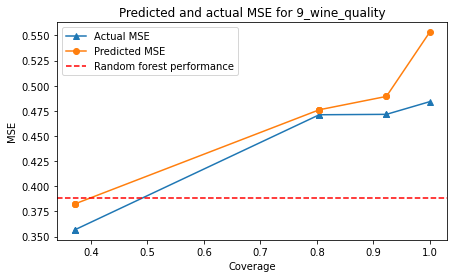

In [19]:
plot_stats('9_wine_quality')

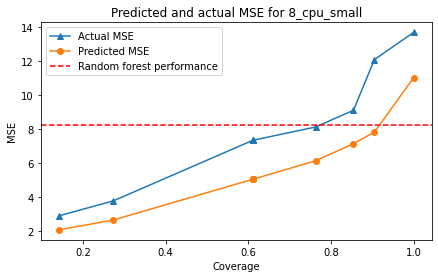

In [20]:
plot_stats('8_cpu_small')

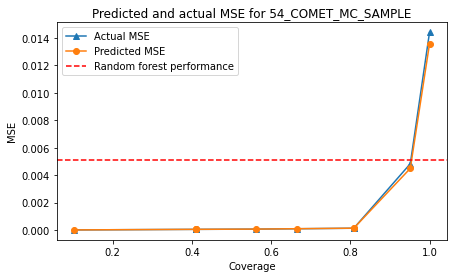

In [21]:
plot_stats('54_COMET_MC_SAMPLE')

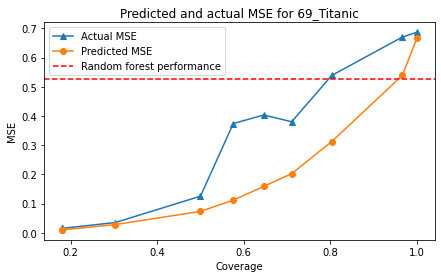

In [22]:
plot_stats('69_Titanic')

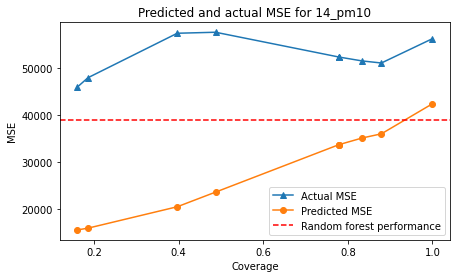

In [23]:
plot_stats('14_pm10')

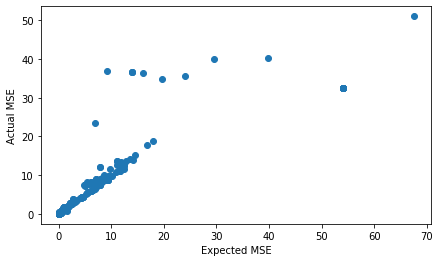

In [24]:
mask = (data['mse_expected'] < 100) & (data['mse_filtered'] < 100)

plt.scatter(data['mse_expected'][mask], data['mse_filtered'][mask])
plt.xlabel('Expected MSE')
plt.ylabel('Actual MSE')
save('expected to actual')
plt.show()

In [25]:
data['coverage'].corr(data['mse_prop_base'])

0.5669670615730236

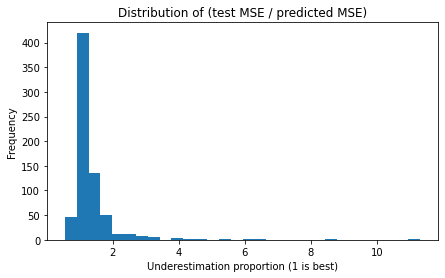

In [26]:
plt.hist(data['mse_filtered'] / data['mse_expected'], bins=30)

plt.title('Distribution of (test MSE / predicted MSE)')
plt.xlabel('Underestimation proportion (1 is best)')
plt.ylabel('Frequency')
save('underestimation dist')
plt.show()

In [27]:
ratios =  data['mse_filtered'] / data['mse_expected']
ratios.mean(), ratios.std()

(1.3249373860622746, 0.7415024210816066)

In [28]:
ratios.mean() + 1.96 * ratios.std()

2.7782821313822232

In [29]:
(ratios > 1.5).mean()

0.17285714285714285

In [30]:
wc = RESULTS['9_wine_quality']
wc['comparison_loss'] < wc['mse_filtered']

0    False
1    False
2    False
3     True
4     True
5     True
6     True
7     True
8     True
9     True
dtype: bool

In [31]:
wc['coverage'][wc['mse_filtered'] < wc['comparison_loss']].max()

0.3710546574287914

In [32]:
def find_max_coverage_perfmatch(name):
    stats = RESULTS[name]
    comparison = stats['coverage'][stats['mse_filtered'] < stats['comparison_loss']]
    if comparison.size:
        return comparison.max()
    return 0

In [33]:
find_max_coverage_perfmatch('54_COMET_MC_SAMPLE')

0.9514154232324641

In [34]:
find_max_coverage_perfmatch('14_pm10')

0

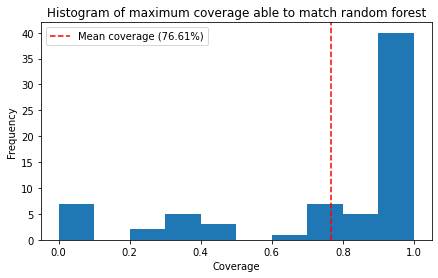

In [35]:
perfmatch = np.array([*map(find_max_coverage_perfmatch, RESULTS.keys())])

plt.hist(perfmatch, bins=10)
plt.axvline(perfmatch.mean(), color='r', linestyle='--',
            label=f'Mean coverage ({perfmatch.mean():.2%})')

plt.title('Histogram of maximum coverage able to match random forest')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
save('cov-hist')
plt.show()

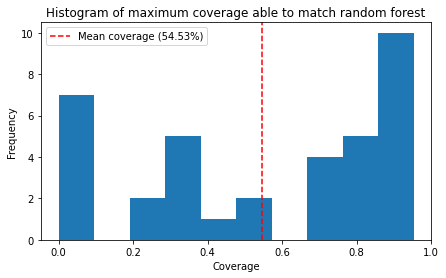

In [36]:
perfmatch_no1 = perfmatch[perfmatch != 1]

plt.hist(perfmatch_no1, bins=10)
plt.axvline(perfmatch_no1.mean(), color='r', linestyle='--',
            label=f'Mean coverage ({perfmatch_no1.mean():.2%})')

plt.title('Histogram of maximum coverage able to match random forest')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
save('cov-hist-no1')
plt.show()

In [37]:
perfmatch

array([0.        , 1.        , 1.        , 0.89694042, 1.        ,
       0.        , 1.        , 0.84530588, 0.06532663, 0.69477912,
       1.        , 1.        , 0.76282051, 0.49954007, 0.9017094 ,
       0.95347306, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.87969925, 1.        , 1.        , 1.        , 1.        ,
       0.79396985, 1.        , 0.        , 1.        , 1.        ,
       1.        , 0.73399015, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.93233083,
       0.37317414, 0.95141542, 0.8921131 , 0.276907  , 1.        ,
       0.49785408, 0.90332492, 0.        , 0.        , 0.37518759,
       0.7873937 , 1.        , 0.72985782, 0.89420655, 1.        ,
       1.        , 0.71067416, 0.        , 0.30782123, 0.3026796 ,
       0.90234588, 0.21398046, 0.41654702, 0.76282051, 0.37105466])